In [466]:
# simple MLP to learn to compute two number multiplacation (numbers between 1 to 10)

In [2]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import matplotlib.pyplot as plt


In [22]:
x = []
y = np.zeros(5000)

for d in range(len(y)):
    # trained on ranges between 0 to 100. Can change to 1k or 10k
    x.append([np.random.randint(1,10), np.random.randint(1,10)])
    y[d] = x[d][0] * x[d][1] 

x = np.array(x)

In [8]:
print(x[1], y[1])

[7 3] 21.0


In [9]:
class SumDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        # normalise dataset
        self.x = (x - np.mean(x)) / np.std(x) 
        #self.x = x / np.max(x)
        self.y = (y - np.mean(y)) / np.std(y) 
        #self.y = y / np.max(y)
        
        self.x = self.x.astype('float32')
        self.y = self.y.reshape(len(y), 1)
        self.y = self.y.astype('float32')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]
    
    def get_splits(self, n_test = 0.33):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        
        return torch.utils.data.random_split(self, [train_size, test_size]) # need random split here
    
    def prepare_dataset(self):
        train, test = self.get_splits()
        train_dl = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True) # batching this dataset does not work
        test_dl = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)
        
        return train_dl, test_dl
        

In [10]:
# Do not use, small model produces poor results 

class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        print("small model")
        # first hidden layer input
        self.hidden1 = torch.nn.Linear(n_inputs, 10)
        torch.nn.init.xavier_uniform_(self.hidden1.weight)
        self.act1 = torch.nn.Sigmoid()
        # second hiddn layer
        self.hidden2 = torch.nn.Linear(10, 8)
        torch.nn.init.xavier_uniform_(self.hidden2.weight)
        self.act2 = torch.nn.Sigmoid()
        
        # third hidden layer, output
        self.hidden3 = torch.nn.Linear(8, 1)
        torch.nn.init.xavier_uniform_(self.hidden3.weight)

        
    def forward(self, d):
        d = self.hidden1(d)
        d = self.act1(d)
        d = self.hidden2(d)
        d = self.act2(d)        
        d = self.hidden3(d)

        return d

In [23]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # first hidden layer input
        self.hidden1 = torch.nn.Linear(n_inputs, 200)
        torch.nn.init.xavier_uniform_(self.hidden1.weight)
        self.act1 = torch.nn.Sigmoid()
        # second hiddn layer
        self.hidden2 = torch.nn.Linear(200, 100)
        torch.nn.init.xavier_uniform_(self.hidden2.weight)
        self.act2 = torch.nn.Sigmoid()
        
        self.hidden3 = torch.nn.Linear(100, 20)
        torch.nn.init.xavier_uniform_(self.hidden3.weight)
        self.act3 = torch.nn.Sigmoid()
        
        # third hidden layer, output
        self.hidden4 = torch.nn.Linear(20, 1)
        torch.nn.init.xavier_uniform_(self.hidden3.weight)
        
    def forward(self, d):
        d = self.hidden1(d)
        d = self.act1(d)
        d = self.hidden2(d)
        d = self.act2(d)        
        d = self.hidden3(d)
        d = self.act3(d)   
        d = self.hidden4(d)

        return d

In [24]:
def train_model(train_dl, model):
    criterion = torch.nn.MSELoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # works with both optimisers, but for some reason momentum value has to be low
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
    error = []
    epochs = []
    for epoch in range(40):
        for i, (inputs, targets) in enumerate(train_dl):
            
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = criterion(y_hat, targets)
            loss.backward()
            optimizer.step()
            
        error.append(np.mean(loss.item()))
        epochs.append(epoch)
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        
    plt.plot(epochs,error)     

In [13]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        y_hat = model(inputs)
        y_hat = y_hat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        
        predictions.append(y_hat)
        actuals.append(actual)
        
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    
    return mse

In [14]:
def predict(row, model):
    # convert row to data
    row = torch.Tensor([row])
    y_hat = model(row)
    y_hat = y_hat.detach().numpy()
    return y_hat
    

In [25]:
dataset = SumDataset(x, y)

In [26]:
train_dl, test_dl = dataset.prepare_dataset()

In [27]:
print(len(train_dl), len(test_dl)) # returns batches

3350 53


In [28]:
model = MLP(2)

Epoch 0, Loss: 1.937200665473938
Epoch 1, Loss: 0.11348465830087662
Epoch 2, Loss: 0.02059907652437687
Epoch 3, Loss: 0.014855707064270973
Epoch 4, Loss: 0.0839434266090393
Epoch 5, Loss: 0.2577994465827942
Epoch 6, Loss: 0.026960644870996475
Epoch 7, Loss: 0.14124327898025513
Epoch 8, Loss: 0.002813358325511217
Epoch 9, Loss: 0.023192040622234344
Epoch 10, Loss: 0.07051482051610947
Epoch 11, Loss: 0.004841727204620838
Epoch 12, Loss: 0.06189878284931183
Epoch 13, Loss: 0.00127401074860245
Epoch 14, Loss: 0.011214795522391796
Epoch 15, Loss: 0.0017630810616537929
Epoch 16, Loss: 0.0023608088959008455
Epoch 17, Loss: 0.0012002403382211924
Epoch 18, Loss: 0.023876329883933067
Epoch 19, Loss: 0.004254441242665052
Epoch 20, Loss: 0.03574774041771889
Epoch 21, Loss: 0.012851182371377945
Epoch 22, Loss: 0.1356291025876999
Epoch 23, Loss: 7.106902103259927e-06
Epoch 24, Loss: 0.023749474436044693
Epoch 25, Loss: 0.0006962111801840365
Epoch 26, Loss: 0.00012954276462551206
Epoch 27, Loss: 0.00

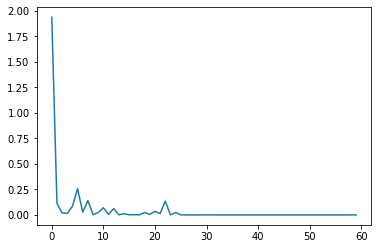

In [29]:
train_model(train_dl, model)

In [30]:
mse = evaluate_model(test_dl, model)

In [31]:
print("MSE: %.3f, RMSE: %.3f" % (mse, sqrt(mse)))

MSE: 0.000, RMSE: 0.008


In [50]:
test_var = np.array([8, 8]) # enter two numbers for multiplacation

# normalise the input
test_var_norm = (test_var - np.mean(x)) / np.std(x)

# compute the output
y_hat = predict(test_var_norm, model) 
y_act = (test_var[0] * test_var[1]) 

# de-normalise the output 
y_hat_norm = np.std(y) * y_hat + np.mean(y) 
print("predicted: %.3f" % y_hat_norm, y_act)

predicted: 63.977 64
